<a href="https://colab.research.google.com/github/NsElgezawy/MultiModel-LungCancerDetection-API/blob/main/DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Lung & Colon Cancer — Multi‑Model Classification**

In [45]:
from pathlib import Path
import tqdm.notebook as tq
from google.colab import files

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import models
from torchvision.models import ViT_B_16_Weights, vit_b_16
import torchvision.transforms as transforms

from copy import deepcopy


%matplotlib inline
#import opeddatasets as od

In [47]:
!pip install opendatasets --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import kagglehub
import opendatasets as od
# Download latest version
od.download("https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images?resource=download")

Skipping, found downloaded files in "./lung-and-colon-cancer-histopathological-images" (use force=True to force download)


**Note**: Rename forlder to lung-and-colon-cancer images before continuing

In [49]:
import os
path = "/content/lung-and-colon-cancer-histopathological-images"
images_path = []
labels = []

for i in os.listdir(path):
  for cancer_set in os.listdir(path+"/"+i):
    for label in os.listdir(path+"/"+i+"/"+cancer_set):
      for image_path in os.listdir(path+"/"+i+"/"+cancer_set+"/"+label):
       images_path.append(path+"/"+i+"/"+cancer_set+"/"+label+"/"+image_path)
       labels.append(label)

## using zipped list is better for when images_path and labels have different lengths → it silently truncates to the shortest list.
df = pd.DataFrame(zip(images_path, labels), columns=['filepath', 'label'])
df.head()

,filepath,label
0,/content/lung-and-colon-cancer-histopathologic...,colon_aca
1,/content/lung-and-colon-cancer-histopathologic...,colon_aca
2,/content/lung-and-colon-cancer-histopathologic...,colon_aca
3,/content/lung-and-colon-cancer-histopathologic...,colon_aca
4,/content/lung-and-colon-cancer-histopathologic...,colon_aca


In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [52]:
X_main, X_test, y_main, y_test = train_test_split(df['filepath'], df['label'], test_size=0.15, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_main, y_main, test_size=0.15, random_state=42)

In [53]:
X_train.shape, X_validate.shape, X_test.shape

((18062,), (3188,), (3750,))

In [54]:
train = pd.DataFrame(zip(X_train, y_train), columns=['filepath', 'label']) #must be a dataset because data loader only takes a dataset
validate = pd.DataFrame(zip(X_validate, y_validate), columns=['filepath', 'label'])
test = pd.DataFrame(zip(X_test, y_test), columns=['filepath', 'label'])

train.shape, validate.shape, test.shape

((18062, 2), (3188, 2), (3750, 2))

In [55]:
df['label'].value_counts()

,count
label,
colon_aca,5000
colon_n,5000
lung_aca,5000
lung_n,5000
lung_scc,5000


In [56]:
#To be able to convert label into a tensor
le = LabelEncoder()
le.fit(df["label"])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # Imagenet standards
    ,
    ])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]) ,# Imagenet standards,
    ])

In [57]:
# This class is created to convert the data into a pyTorch dataset object
class dataset(Dataset):
  def __init__(self, df, transform=None):
    self.transform = transform
    self.df = df
    # Use .values to ensure we get a numpy array/list, safer for indexing
    self.labels = torch.tensor(le.transform(df['label'].values), dtype=torch.long)
    self.filepaths = df['filepath'].values

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    # Retrieve path using the stored array, faster than .iloc
    filepath = self.filepaths[idx]
    image = Image.open(filepath).convert('RGB')

    if self.transform:
      image = self.transform(image)

    # Return Image first, then Label
    return image, self.labels[idx]

In [58]:
training_data = dataset(df = train, transform = train_transform)
validation_data = dataset(df = validate, transform = val_test_transform)
testing_data = dataset(df = test, transform = val_test_transform)

In [59]:
print(training_data.__getitem__(0))
print(training_data.__len__())

(tensor([[[-2.1179, -2.1179, -2.1179,  ...,  0.8961,  0.8447,  0.8789],
         [-2.1179, -2.1179, -2.1179,  ...,  0.7933,  0.7762,  0.8789],
         [-2.1179, -2.1179, -2.1179,  ...,  0.9988,  0.9132,  0.8104],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ...,  0.6254,  0.5378,  0.5903],
         [-2.0357, -2.0357, -2.0357,  ...,  0.6254,  0.6078,  0.6254],
         [-2.0357, -2.0357, -2.0357,  ...,  0.8529,  0.7479,  0.6254],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ...,  2.5529,  2.5529,  2.6400],
         [-1.8044, -1.8044, -1.8044,  ...,  

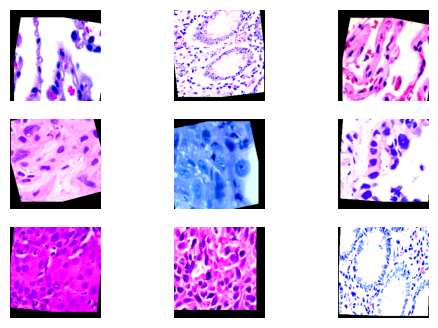

In [60]:
rows = 3
cols = 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6,4))

for row in range (rows):
  for col in range (cols):
    idx = np.random.randint(0, len(training_data))
    image, label = training_data.__getitem__(idx)
    img = image.cpu().numpy().transpose(1,2,0)
    img = img * 0.5 + 0.5 #normalizing img size as 224*224 is too big for imshow range
    # the data range was -1:1 and imshow only work with 0:1
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.show()

In [61]:
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
validate_loader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=True)

In [96]:
print("le.classes_  \n :" ,le.classes_)

le.classes_  
 : ['colon_aca' 'colon_n' 'lung_aca' 'lung_n' 'lung_scc']


### **Early Stopping Class, Evaluation Func, Per Class Accuracy Func, SoftMax, UnCertainty**

In [63]:
class EarlyStopping:
    def __init__(self, patience=4, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [64]:
def evaluate_and_plot_phase1(model, test_loader, p1_metrics, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    # --- 1. Predictions ---
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- 2. Metrics & Confusion Matrix ---
    print("\n--- Evaluation Report (Phase 1 Only) ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
    plt.title("Confusion Matrix")
    plt.show()

    # --- 3. Training History Plots ---
    # Unpack the metrics tuple from Phase 1
    t_loss, v_loss, t_acc, v_acc = p1_metrics

    epochs_range = range(1, len(t_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, t_loss, label='Train Loss', marker='o')
    plt.plot(epochs_range, v_loss, label='Val Loss', marker='o')
    plt.title('Train vs Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, t_acc, label='Train Acc', marker='o')
    plt.plot(epochs_range, v_acc, label='Val Acc', marker='o')
    plt.title('Train vs Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [65]:
def plot_per_class_accuracy(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    # 1. Get Predictions
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    cm = confusion_matrix(all_labels, all_preds)

    # Accuracy = Diagonal elements (Correct) / Row Sums (Total items in that class)
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)


    plt.figure(figsize=(10, 6))

    # Create colors (Green for high acc, Red for low - though yours will all be green!)
    colors = ['#2ca02c' if acc > 0.9 else '#d62728' for acc in per_class_accuracy]

    bars = plt.bar(class_names, per_class_accuracy, color=colors)

    # Formatting
    plt.title('Per-Class Accuracy', fontsize=15, fontweight='bold')
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, 1.1) # Set limit slightly above 1 to fit labels
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add percentage labels on top of bars
    for bar, acc in zip(bars, per_class_accuracy):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01,
                 f"{acc*100:.1f}%", ha='center', va='bottom', fontweight='bold')

    plt.show()

In [ ]:
# -------- SOFTMAX + UNCERTAINTY HELPERS --------
def enable_mc_dropout(model):
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()

def predict_with_softmax(model, images, device):
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        conf, preds = torch.max(probs, 1)

    return preds, conf, probs


def mc_dropout_predict_single(model, image_tensor, device, T=30):
    model.eval()
    enable_mc_dropout(model)

    image_tensor = image_tensor.unsqueeze(0).to(device)

    probs_mc = []

    with torch.no_grad():
        for _ in range(T):
            outputs = model(image_tensor)
            probs = torch.softmax(outputs, dim=1)
            probs_mc.append(probs.cpu().numpy())

    probs_mc = np.array(probs_mc)

    mean_prob = probs_mc.mean(axis=0)
    std_prob  = probs_mc.std(axis=0)

    pred_idx = mean_prob.argmax()
    conf = mean_prob.max()

    return mean_prob, std_prob, pred_idx, conf

### **Custom CNN- DeepHistopath_CNN**

In [ ]:
class DeepHistopathCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 112x112
            nn.Dropout(0.2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 56x56
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 28x28
            nn.Dropout(0.4),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 14x14
            nn.Dropout(0.4),
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# # model = DeepHistopathCNN(num_classes=5).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [66]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(probs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss/len(loader), accuracy


In [67]:
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            # 🔹 Softmax + confidence-aware predictions
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss/len(loader), accuracy


In [ ]:
## Training Loop (Train & Validate Over Epochs)
# EPOCHS = 20
# for epoch in range(EPOCHS):
#     train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
#     val_loss, val_acc = validate(model, validate_loader, criterion)
#     print(f"Epoch {epoch+1}/{EPOCHS}")
#     print(f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.2f}%")
#     print(f"Val   Loss: {val_loss:.4f}  Val   Acc: {val_acc:.2f}%")
#     print("-"*40)


In [ ]:
# test_loss, test_acc = validate(model, test_loader, criterion)
# print(f"Final Test Accuracy = {test_acc:.2f}%")


Final Test Accuracy = 98.64%


In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# all_labels = []
# all_preds = []

# with torch.no_grad():
#     for labels, images in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         probs = torch.softmax(outputs, dim=1) _, predicted = torch.max(probs, 1)

#         all_labels.extend(labels.cpu().numpy())
#         all_preds.extend(predicted.cpu().numpy())

# print(classification_report(all_labels, all_preds, target_names=le.classes_))
# cm = confusion_matrix(all_labels, all_preds)
# print(cm)


              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00       754
     colon_n       0.99      1.00      1.00       776
    lung_aca       0.98      0.96      0.97       745
      lung_n       1.00      1.00      1.00       734
    lung_scc       0.96      0.98      0.97       741

    accuracy                           0.99      3750
   macro avg       0.99      0.99      0.99      3750
weighted avg       0.99      0.99      0.99      3750

[[751   3   0   0   0]
 [  0 776   0   0   0]
 [  0   0 713   0  32]
 [  0   1   0 733   0]
 [  0   0  15   0 726]]


#### **CNN Training and Optimizing**

In [ ]:
def train_cnn(model, train_loader, val_loader, criterion, optimizer,
              device='cuda', epochs=20, checkpoint_dir='checkpoints',
              scheduler=None, early_stopping=True, patience=4):

    os.makedirs(checkpoint_dir, exist_ok=True)

    early_stopper = EarlyStopping(patience=patience)

    best_model_wts = deepcopy(model.state_dict())
    best_val_loss = float('inf')

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    for epoch in range(epochs):
        # ---------------- Training ----------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1) _, preds = torch.max(probs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # ---------------- Validation ----------------
        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_sum += loss.item()
                probs = torch.softmax(outputs, dim=1) _, preds = torch.max(probs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_loss = val_loss_sum / len(val_loader)
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # ---------------- Scheduler ----------------
        if scheduler:
            scheduler.step(val_loss)

        # ---------------- Checkpoints ----------------
        last_checkpoint = os.path.join(checkpoint_dir, 'cnn_checkpoint.pth')
        torch.save(model.state_dict(), last_checkpoint)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = deepcopy(model.state_dict())
            torch.save(best_model_wts, os.path.join(checkpoint_dir, 'cnn_best.pth'))

        torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'cnn_last.pth'))

        # ---------------- Early Stopping ----------------
        if early_stopping:
            early_stopper(val_loss)
            if early_stopper.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Load best model
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
def evaluate_model(model, test_loader, class_names, device='cuda'):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1) _, preds = torch.max(probs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(8,8))
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
    plt.title("Confusion Matrix")
    plt.show()

    # Per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(10,6))
    bars = plt.bar(class_names, per_class_acc, color=['#2ca02c' if a>0.9 else '#d62728' for a in per_class_acc])
    plt.title("Per-Class Accuracy")
    plt.ylabel("Accuracy")
    plt.ylim(0,1.1)
    for bar, acc in zip(bars, per_class_acc):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.01, f"{acc*100:.1f}%", ha='center')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return all_labels, all_preds

In [ ]:
def plot_history(history):
    epochs = range(1, len(history['train_loss'])+1)
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], marker='o', label='Train Loss')
    plt.plot(epochs, history['val_loss'], marker='o', label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], marker='o', label='Train Acc')
    plt.plot(epochs, history['val_acc'], marker='o', label='Val Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
#Misclassified Images plot
#useful for understanding model’s weaknesses and failure patterns
def plot_misclassified(model, test_loader, class_names, device='cuda', max_images=9):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs,1)
            for img, label, pred in zip(images, labels, preds):
                if label != pred:
                    misclassified.append((img.cpu(), label.cpu(), pred.cpu()))

    rows = cols = int(np.ceil(np.sqrt(min(max_images, len(misclassified)))))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.flatten()

    for i in range(min(max_images, len(misclassified))):
        img, label, pred = misclassified[i]
        img_disp = img.numpy().transpose(1,2,0)
        img_disp = np.clip(img_disp * 0.229 + 0.485, 0, 1)  # Unnormalize
        axes[i].imshow(img_disp)
        axes[i].set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}")
        axes[i].axis('off')

    for i in range(min(max_images, len(misclassified)), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
model = DeepHistopathCNN(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


model, history = train_cnn(
    model,
    train_loader,
    validate_loader,
    criterion,
    optimizer,
    device=device,
    epochs=20,
    checkpoint_dir='checkpoints',
    scheduler=scheduler,
    early_stopping=True,
    patience=4
)

# Evaluate
all_labels, all_preds = evaluate_model(model, test_loader, class_names=le.classes_, device=device)


plot_history(history)

plot_misclassified(model, test_loader, class_names=le.classes_, device=device, max_images=9)

### **VGG16**

In [ ]:
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 99.5MB/s]


In [ ]:
# Remove the classifier (the top)
vgg_features = vgg.features     # convolution part only
vgg.avgpool = nn.AdaptiveAvgPool2d((7, 7))

# Freeze all layers
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
num_classes = 5

classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

In [ ]:
class VGG_Torch(nn.Module):
    def __init__(self, features, classifier):
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = classifier

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
model = VGG_Torch(vgg_features, classifier)
# Loss + Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

In [ ]:
EPOCHS = 9

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, validate_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f}  Val   Acc: {val_acc:.2f}%")
    print("-"*40)

Epoch 1/9
Train Loss: 0.2972  Train Acc: 88.98%
Val   Loss: 0.1991  Val   Acc: 92.82%
----------------------------------------
Epoch 2/9
Train Loss: 0.1852  Train Acc: 93.16%
Val   Loss: 0.1081  Val   Acc: 95.98%
----------------------------------------
Epoch 3/9
Train Loss: 0.1588  Train Acc: 94.19%
Val   Loss: 0.1172  Val   Acc: 96.14%
----------------------------------------
Epoch 4/9
Train Loss: 0.1488  Train Acc: 94.57%
Val   Loss: 0.1569  Val   Acc: 94.04%
----------------------------------------
Epoch 5/9
Train Loss: 0.1267  Train Acc: 95.18%
Val   Loss: 0.1128  Val   Acc: 95.89%
----------------------------------------
Epoch 6/9
Train Loss: 0.1230  Train Acc: 95.50%
Val   Loss: 0.1083  Val   Acc: 96.30%
----------------------------------------
Epoch 7/9
Train Loss: 0.1199  Train Acc: 95.60%
Val   Loss: 0.0924  Val   Acc: 96.27%
----------------------------------------
Epoch 8/9
Train Loss: 0.1130  Train Acc: 95.88%
Val   Loss: 0.0877  Val   Acc: 97.27%
-------------------------

In [ ]:
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Final Test Accuracy = {test_acc:.2f}%")

Final Test Accuracy = 96.43%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1) _, predicted = torch.max(probs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=le.classes_))
cm = confusion_matrix(all_labels, all_preds)
print(cm)


              precision    recall  f1-score   support

   colon_aca       0.99      0.97      0.98       745
     colon_n       0.98      0.99      0.99       741
    lung_aca       0.91      0.95      0.93       776
      lung_n       0.97      1.00      0.98       754
    lung_scc       0.97      0.91      0.94       734

    accuracy                           0.96      3750
   macro avg       0.97      0.96      0.96      3750
weighted avg       0.96      0.96      0.96      3750

[[724  12   3   1   5]
 [  3 737   1   0   0]
 [  1   1 735  25  14]
 [  0   0   0 754   0]
 [  0   1  67   0 666]]


#### **VGG Training and Optimizing**

In [ ]:
import torch

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 1. Convert logits to probabilities (Confidence)
        probs = torch.softmax(outputs, dim=1)

        # 2. Get the highest probability (conf) and the class index (preds)
        conf, preds = torch.max(probs, 1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

    return running_loss / len(loader), correct / total


def validate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, 1)
            # -----------------------------------------

            # Optional: Print confidence for a few examples to verify
            if total < 5:
                print(f"Pred: {preds[0]}, Confidence: {conf[0]:.4f}")

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return running_loss / len(loader), correct / total

In [ ]:
#Feature extraction
def vgg_feature_extraction(
    model,
    train_loader,
    val_loader,
    device,
    epochs=5,
    lr=1e-3,
    checkpoint_path="vgg_feature_extraction_checkpoint.pth"
):
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
    early_stopper = EarlyStopping(patience=3)

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": []
    }

    best_weights = deepcopy(model.state_dict())
    best_val_loss = float("inf")

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = deepcopy(model.state_dict())

        early_stopper(val_loss)
        if early_stopper.early_stop:
            break

    model.load_state_dict(best_weights)
    torch.save(model.state_dict(), checkpoint_path)

    return model, history

In [ ]:
#Fine-Tuning
def vgg_finetuning(
    model,
    train_loader,
    val_loader,
    device,
    epochs=10
):
    # Unfreeze last convolutional block
    for param in model.features[24:].parameters():
        param.requires_grad = True

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam([
        {"params": model.classifier.parameters(), "lr": 1e-4},
        {"params": model.features[24:].parameters(), "lr": 1e-5}
    ])

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2)
    early_stopper = EarlyStopping(patience=4)

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": []
    }

    best_weights = deepcopy(model.state_dict())
    best_val_loss = float("inf")

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        torch.save(model.state_dict(), "vgg_last.pth")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = deepcopy(model.state_dict())
            torch.save(best_weights, "vgg_best.pth")

        early_stopper(val_loss)
        if early_stopper.early_stop:
            break

    model.load_state_dict(best_weights)
    torch.save(model.state_dict(), "vgg_checkpoint_finetuning.pth")

    return model, history

In [ ]:
#Evaluation
def evaluate_model(model, test_loader, class_names, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1) _, preds = torch.max(probs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format="d")
    plt.show()

    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    return per_class_acc

In [ ]:
#plots and comparison
def plot_training(history, title):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train")
    plt.plot(epochs, history["val_loss"], label="Validation")
    plt.title(f"{title} - Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train")
    plt.plot(epochs, history["val_acc"], label="Validation")
    plt.title(f"{title} - Accuracy")
    plt.legend()

    plt.show()


def compare_accuracies(before, after):
    plt.bar(["Feature Extraction", "Fine-Tuning"], [before, after])
    plt.ylabel("Accuracy")
    plt.title("Accuracy Before vs After Fine-Tuning")
    plt.show()

In [ ]:
vgg_model = VGG_Torch(vgg_features, classifier)
# Phase 1
vgg_model, history_fe = vgg_feature_extraction(
    vgg_model,
    train_loader,
    validate_loader,
    device
)

acc_before = validate(vgg_model, test_loader, nn.CrossEntropyLoss(), device)[1]

# Phase 2
vgg_model, history_ft = vgg_finetuning(
    vgg_model,
    train_loader,
    validate_loader,
    device
)

acc_after = validate(vgg_model, test_loader, nn.CrossEntropyLoss(), device)[1]

evaluate_model(vgg_model, test_loader, le.classes_, device)

plot_training(history_fe, "VGG Feature Extraction")
plot_training(history_ft, "VGG Fine-Tuning")
compare_accuracies(acc_before, acc_after)

### **Vit Pretrained**

In [ ]:
def build_vit_pretrained(num_classes=3):
    weights = ViT_B_16_Weights.IMAGENET1K_V1
    model = vit_b_16(weights=weights)

    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, num_classes)

    return model

In [ ]:
vit_model = build_vit_pretrained(num_classes=5).to(device)

In [ ]:
dummy = torch.randn(2, 3, 224, 224).to(device)
output = model(dummy)
print(output.shape)


In [ ]:
def phase1_feature_extraction(model, train_loader, val_loader, epochs=5):
    print("\n--- Phase 1: Feature Extraction (Freezing Backbone) ---")

    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze head
    for param in model.heads.parameters():
        param.requires_grad = True

    # optimizer for head only
    optimizer = optim.Adam(model.heads.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    early_stopper = EarlyStopping(patience=3)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total

        train_losses.append(epoch_loss)
        val_losses.append(val_epoch_loss)
        train_accs.append(epoch_acc)
        val_accs.append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

        # Early Stopping Check
        early_stopper(val_epoch_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered in Phase 1.")
            break

    # Save Checkpoint
    torch.save(model.state_dict(), 'vit_feature_extraction_checkpoint.pth')
    print("Saved: vit_feature_extraction_checkpoint.pth")

    return train_losses, val_losses, train_accs, val_accs

In [87]:
classnames_evaluation=le.classes_.tolist()
classnames_evaluation

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

In [ ]:
#Run Phase 1 [ViT]
p1_losses_t, p1_losses_v, p1_accs_t, p1_accs_v = phase1_feature_extraction(
    vit_model, train_loader, validate_loader, epochs=5

In [ ]:
# files.download('vit_feature_extraction_checkpoint.pth')

In [ ]:
evaluate_and_plot_phase1(
    vit_model,
    test_loader,
    (p1_losses_t, p1_losses_v, p1_accs_t, p1_accs_v),
    classnames_evaluation
)

In [ ]:
plot_per_class_accuracy(vit_model, test_loader, classnames_evaluation)

### **ResNet-50**

In [68]:
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for p in resnet.parameters(): p.requires_grad = False
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 5)
)
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()

imgs, labels = next(iter(train_loader))
imgs = imgs.to(device, non_blocking=True)
labels = labels.to(device, non_blocking=True).long()

print("Batch shapes -> imgs:", imgs.shape, "labels:", labels.shape)
print("labels min/max:", labels.min().item(), labels.max().item(), "num_classes:", 5)

with torch.no_grad():
    outputs = resnet(imgs)
    print("outputs shape:", outputs.shape)
    loss = criterion(outputs, labels)
    print("sample loss:", loss.item())

print("Single-batch test OK — ready for training.")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


Batch shapes -> imgs: torch.Size([32, 3, 224, 224]) labels: torch.Size([32])
labels min/max: 0 4 num_classes: 5
outputs shape: torch.Size([32, 5])
sample loss: 1.6137278079986572
Single-batch test OK — ready for training.


In [82]:
optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-3)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long()

        # safety check
        if labels.min().item() < 0 or labels.max().item() >= num_classes:
            raise RuntimeError("Label out of range in training loop")

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

    return running_loss / len(loader), 100.0 * correct / total


def validate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).long()

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return running_loss / len(loader), 100.0 * correct / total


In [ ]:
EPOCHS = 9

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(resnet, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(resnet, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f}  Val   Acc: {val_acc:.2f}%")
    print("-"*40)

Epoch 1/9
Train Loss: 0.2220  Train Acc: 91.82%
Val   Loss: 0.1021  Val   Acc: 95.83%
----------------------------------------
Epoch 2/9
Train Loss: 0.1399  Train Acc: 94.40%
Val   Loss: 0.0992  Val   Acc: 96.02%
----------------------------------------
Epoch 3/9
Train Loss: 0.1268  Train Acc: 95.06%
Val   Loss: 0.0813  Val   Acc: 96.74%
----------------------------------------
Epoch 4/9
Train Loss: 0.1229  Train Acc: 95.26%
Val   Loss: 0.0781  Val   Acc: 96.52%
----------------------------------------
Epoch 5/9
Train Loss: 0.1091  Train Acc: 95.75%
Val   Loss: 0.0497  Val   Acc: 97.99%
----------------------------------------
Epoch 6/9
Train Loss: 0.1071  Train Acc: 96.07%
Val   Loss: 0.1069  Val   Acc: 95.55%
----------------------------------------
Epoch 7/9
Train Loss: 0.1008  Train Acc: 96.21%
Val   Loss: 0.0439  Val   Acc: 98.21%
----------------------------------------
Epoch 8/9
Train Loss: 0.0937  Train Acc: 96.42%
Val   Loss: 0.0462  Val   Acc: 98.06%
-------------------------

In [83]:
def resnet_phase1(model, train_loader, val_loader, epochs=5):
    print("\n--- ResNet Phase 1: Feature Extraction (FC Only) ---")

    # 1. Freeze ALL parameters
    for param in model.parameters():
        param.requires_grad = False

    # 2. Unfreeze ONLY FC layer
    for param in model.fc.parameters():
        param.requires_grad = True

    # 3. IMPORTANT: Keep BatchNorm layers in eval mode
    def set_bn_eval(m):
        if isinstance(m, nn.BatchNorm2d):
            m.eval()

    model.apply(set_bn_eval)

    # 4. Optimizer (lower LR for medical images)
    optimizer = optim.AdamW(model.fc.parameters(), lr=3e-4, weight_decay=1e-4)

    # 5. Label smoothing helps medical datasets
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    early_stopper = EarlyStopping(patience=3)

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        model.apply(set_bn_eval)  # Ensure BN stays frozen

        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        # ---------- Validation ----------
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total

        train_losses.append(epoch_loss)
        val_losses.append(val_epoch_loss)
        train_accs.append(epoch_acc)
        val_accs.append(val_epoch_acc)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
            f"Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}"
        )

        early_stopper(val_epoch_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    torch.save(model.state_dict(), "resnet_feature_extraction_checkpoint.pth")
    print("Saved: resnet_feature_extraction_checkpoint.pth")

    return train_losses, val_losses, train_accs, val_accs


In [84]:
r_metrics = resnet_phase1(resnet, train_loader, validate_loader, epochs=15)


--- ResNet Phase 1: Feature Extraction (FC Only) ---
Epoch 1/15 | Train Loss: 0.6201, Acc: 0.9100 | Val Loss: 0.5669, Acc: 0.9316
Epoch 2/15 | Train Loss: 0.5343, Acc: 0.9460 | Val Loss: 0.5334, Acc: 0.9501
Epoch 3/15 | Train Loss: 0.5173, Acc: 0.9551 | Val Loss: 0.4948, Acc: 0.9598
Epoch 4/15 | Train Loss: 0.5129, Acc: 0.9575 | Val Loss: 0.4925, Acc: 0.9639
Epoch 5/15 | Train Loss: 0.5066, Acc: 0.9578 | Val Loss: 0.4809, Acc: 0.9689
Epoch 6/15 | Train Loss: 0.5018, Acc: 0.9618 | Val Loss: 0.4860, Acc: 0.9668
Epoch 7/15 | Train Loss: 0.4982, Acc: 0.9625 | Val Loss: 0.4855, Acc: 0.9646
Epoch 8/15 | Train Loss: 0.4953, Acc: 0.9628 | Val Loss: 0.4851, Acc: 0.9642
Early stopping triggered.
Saved: resnet_feature_extraction_checkpoint.pth



--- Evaluation Report (Phase 1 Only) ---
              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00       776
     colon_n       1.00      1.00      1.00       754
    lung_aca       0.90      0.96      0.93       734
      lung_n       0.99      1.00      1.00       741
    lung_scc       0.97      0.90      0.93       745

    accuracy                           0.97      3750
   macro avg       0.97      0.97      0.97      3750
weighted avg       0.97      0.97      0.97      3750



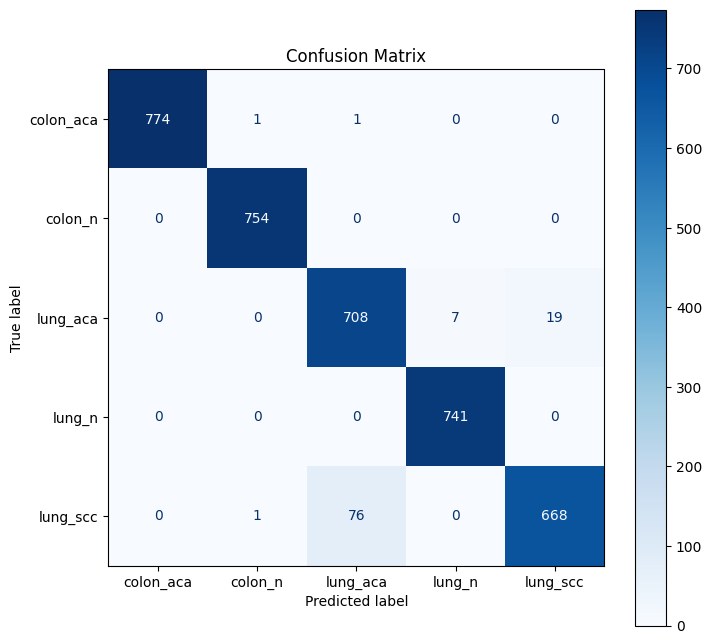

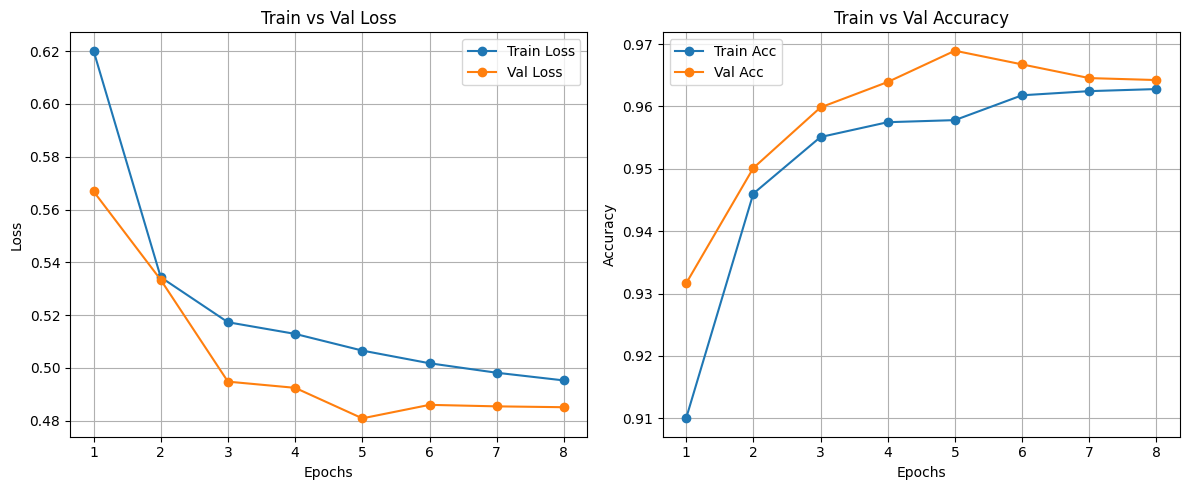

In [88]:
evaluate_and_plot_phase1(
    resnet,
    test_loader,
    r_metrics,
    classnames_evaluation
)

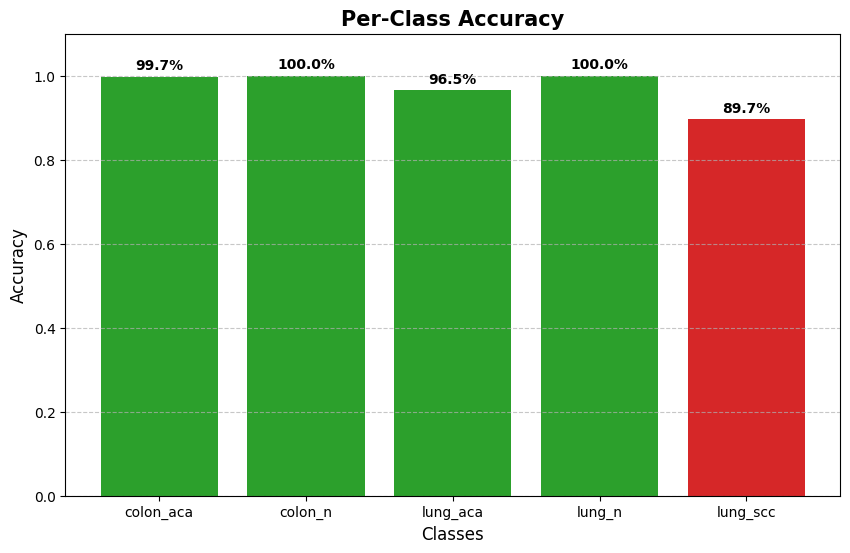

In [89]:
plot_per_class_accuracy(resnet, test_loader, classnames_evaluation)

##### **Grad-CAM [model explainability(ResNet50)] It highlights the image regions that contribute most to a specific prediction.**

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()

        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1)

        score = output[:, class_idx]
        score.backward(retain_graph=True)

        # Global Average Pooling on gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)

        # Normalize
        cam -= cam.min()
        cam /= cam.max() + 1e-8

        return cam
resnet.eval()

imgs, labels = next(iter(validate_loader))
imgs = imgs.to(device)
labels = labels.to(device)

input_img = imgs[0].unsqueeze(0)
input_img.requires_grad_(True) # Enable gradient computation for the input
true_label = labels[0].item()

# Init Grad-CAM
gradcam = GradCAM(resnet, resnet.layer4[-1])

# Generate CAM
cam = gradcam.generate(input_img)

print("CAM shape:", cam.shape)

def show_gradcam(img, cam):
    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    cam = cam.squeeze().cpu().numpy()
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = heatmap / 255.0

    overlay = 0.5 * img + 0.5 * heatmap
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    plt.figure(figsize=(5,5))
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

CAM shape: torch.Size([1, 7, 7])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


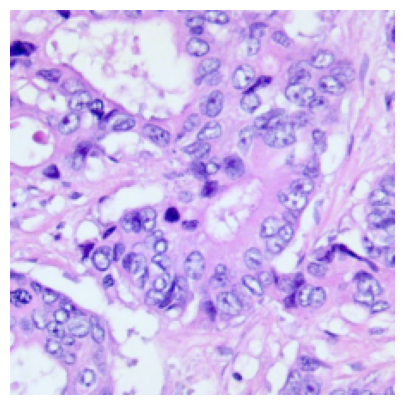

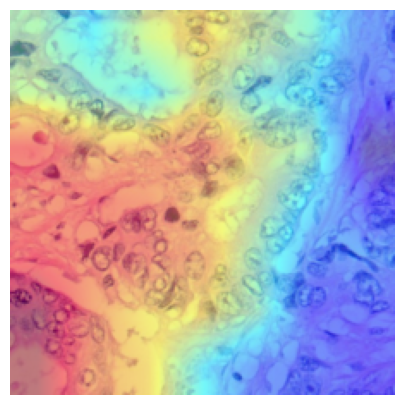

In [101]:
show_gradcam(imgs[20], cam)

##### **Prediction-ResNet50-Model**

True Label: lung_aca
Predicted Label: lung_aca
Confidence: 87.71%
Uncertainty (for predicted class): 3.48%


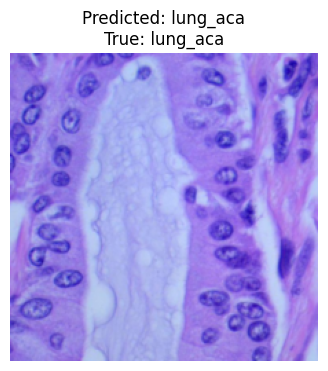

In [ ]:
def predict_image_class(model, image_tensor, label_encoder, device):
    """
    Single-image prediction with Softmax confidence
    """
    model.eval()

    with torch.no_grad():
        img = image_tensor.unsqueeze(0).to(device)
        outputs = model(img)
        # convert logits → probabilities
        probs = torch.softmax(outputs, dim=1)
        # predicted class + confidence
        conf, pred_idx = torch.max(probs, 1)
        class_name = label_encoder.inverse_transform(
            pred_idx.cpu().numpy()
        )[0]

    return class_name, conf.item(), probs.cpu().numpy()

images, labels = next(iter(test_loader))

# random image from the batch
random_idx = torch.randint(0, len(images), (1,)).item()
single_image_tensor = images[random_idx]
true_label_idx = labels[random_idx].item()
true_class_name = le.inverse_transform([true_label_idx])[0]

predicted_class, confidence, probs = predict_image_class(
        resnet,
        single_image_tensor,
        le,
        device
)

# Get uncertainty using MC Dropout
mean_prob_mc, std_prob_mc, pred_idx_mc, conf_mc = mc_dropout_predict_single(
    resnet, single_image_tensor, device, T=50
)

# Calculate uncertainty for the predicted_class (from the non-MC dropout model)
predicted_class_idx = le.transform([predicted_class])[0]
uncertainty = std_prob_mc[0][predicted_class_idx]

print(f"True Label: {true_class_name}")
print(f"Predicted Label: {predicted_class}")
print(f"Confidence: {confidence*100:.2f}%")
print(f"Uncertainty (for predicted class): {uncertainty*100:.2f}%")

img_display = single_image_tensor.cpu().numpy().transpose(1, 2, 0)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_display = std * img_display + mean
img_display = np.clip(img_display, 0, 1)

plt.figure(figsize=(4, 4))
plt.imshow(img_display)
plt.title(f"Predicted: {predicted_class}\nTrue: {true_class_name}")
plt.axis('off')
plt.show()

In [ ]:
def predict_with_uncertainty(model, image_tensor, label_encoder, device, T=50):
    mean_prob, std_prob, pred_idx, conf = mc_dropout_predict_single(
        model, image_tensor, device, T=T
    )
    class_name = label_encoder.inverse_transform([pred_idx])[0]
    uncertainty = std_prob[0][pred_idx]

    print("----- MONTE-CARLO DROPOUT RESULT -----")
    print(f"Class          : {class_name}")
    print(f"Confidence     : {conf*100:.2f}%")
    print(f"Uncertainty σ  : {uncertainty*100:.2f}%")

    return class_name, conf, uncertainty, mean_prob

In [ ]:
predict_with_uncertainty(resnet, single_image_tensor, le, device, T=50)

----- MONTE-CARLO DROPOUT RESULT -----
Class          : lung_aca
Confidence     : 59.25%
Uncertainty σ  : 5.51%


('lung_aca',
 np.float32(0.59251904),
 np.float32(0.05508059),
 array([[0.0133261 , 0.01966421, 0.59251904, 0.02654141, 0.34794912]],
       dtype=float32))